<font size=8> DynapSE2 TimeConstant Extraction


In [41]:
#normal python import
from pickle import TRUE
import time
import sys
import os
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.getcwd() + '/..')

#dynapse2 spikegen imports
from lib.dynapse2_util import *
from lib.dynapse2_network import Network
from lib.dynapse2_spikegen import send_events,get_fpga_time, send_virtual_events, poisson_gen, isi_gen,regular_gen
from lib.dynapse2_raster import *
from lib.dynapse2_obj import *


#Statistics imports
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression

#my imports
from configs.neuron_configs import neuron_configs
from adaptation_lib.spike_stats import *
from adaptation_lib.dynapse_setup import *
from adaptation_lib.graphing import *
from adaptation_lib.tc_extraction import *


In [42]:
[board,profile_path,number_of_chips]=obtain_board()

[]


IndexError: list index out of range

<font size=8>TEST SETUP


In [43]:
core_to_measure=0
test_type='AMPA'

In [44]:

#Initialization
model = board.get_model()
model.reset(ResetType.PowerCycle, (1 << number_of_chips) - 1)
time.sleep(1)
myConfig = model.get_configuration()
model.apply_configuration(myConfig)
time.sleep(1)

#Set up network
network = Network(config=myConfig, profile_path=profile_path, num_chips=number_of_chips)
input_neuron_1 = network.add_virtual_group(size=1)#normal input
input_neuron_2 = network.add_virtual_group(size=1)#normal input
input_neuron_3 = network.add_virtual_group(size=1)#normal input
input_neuron_4 = network.add_virtual_group(size=1)#normal input
test_neurons = network.add_group(chip=0, core=core_to_measure, size=255)

#Input Connections
network.add_connection(source=input_neuron_1, target=test_neurons, probability=1,
                  dendrite=Dendrite.ampa, weight=[True, False, False, False],repeat=1)
network.add_connection(source=input_neuron_2, target=test_neurons, probability=1,
                  dendrite=Dendrite.nmda, weight=[False, True, False, False],repeat=1)
network.add_connection(source=input_neuron_3, target=test_neurons, probability=1,
                  dendrite=Dendrite.gaba, weight=[False, False, True, False],repeat=1)
network.add_connection(source=input_neuron_4, target=test_neurons, probability=1,
                  dendrite=Dendrite.shunt, weight=[False, False, False, True],repeat=1)
network.connect()
#set up latches$
set_dc_latches(config=myConfig, neurons=range(256), cores=[0,1,2], chips=range(number_of_chips))
model.apply_configuration(myConfig)
time.sleep(1)   

#Set neurons spiking threadholds to maximum and leakage to maximum
neuron_config=neuron_configs()
set_configs(myConfig,model,neuron_config)
for c in range(4):
    set_parameter(myConfig.chips[0].cores[c].parameters,'SOIF_GAIN_N',0,200)
    set_parameter(myConfig.chips[0].cores[c].parameters,'SOIF_REFR_N',5,250)
    set_parameter(myConfig.chips[0].cores[c].parameters,'SOIF_SPKTHR_P',5,220)
    set_parameter(myConfig.chips[0].cores[c].parameters,'SOIF_LEAK_N',4,250)
    set_parameter(myConfig.chips[0].cores[c].parameters, 'SYAM_W0_P', 5,200) 
    set_parameter(myConfig.chips[0].cores[c].parameters, 'SYAM_W1_P', 5,200) 
    set_parameter(myConfig.chips[0].cores[c].parameters, 'SYAM_W2_P', 5,200) 
    set_parameter(myConfig.chips[0].cores[c].parameters, 'SYAM_W3_P', 5,200) 



    set_parameter(myConfig.chips[0].cores[c].parameters, 'SYPD_EXT_N', 3, 200)
    if test_type=='GABA_A' or test_type=='GABA_B':
        set_parameter(myConfig.chips[0].cores[c].parameters,"SOIF_DC_P", 4, 200)
    elif test_type=='AMPA' or test_type=='NMDA':
        set_parameter(myConfig.chips[0].cores[c].parameters,"SOIF_DC_P", 0, 0)
model.apply_configuration(myConfig)
time.sleep(0.1)

<font size=10> Single Test


In [53]:
#set test parameters
leak_coarse=1
leak_fine=20

neuron_to_measure=11

#input_events=regular_gen(input_neuron,1,10,1)
if test_type=='AMPA':
    #set ampa synapse parameters
    set_parameter(myConfig.chips[0].cores[core_to_measure].parameters,'DEAM_ETAU_P',leak_coarse,leak_fine)
    set_parameter(myConfig.chips[0].cores[core_to_measure].parameters,'DEAM_EGAIN_P',3,60) 
    input_events=isi_gen(input_neuron_1,[0],[0])
    print('AMPA')
elif test_type=='NMDA':    
    #set nmda synapse parameters
    set_parameter(myConfig.chips[0].cores[core_to_measure].parameters, 'DENM_ETAU_P', leak_coarse,leak_fine)#PC to PC
    set_parameter(myConfig.chips[0].cores[core_to_measure].parameters, 'DENM_EGAIN_P', 4,140)
    input_events=isi_gen(input_neuron_2,[0],[0])
elif test_type=='GABA_B':
    #set GABA B slow inhibitory substractive synapse parameters
    set_parameter(myConfig.chips[0].cores[core_to_measure].parameters, 'DEGA_ITAU_P',leak_coarse,leak_fine)# SST to PC
    set_parameter(myConfig.chips[0].cores[core_to_measure].parameters, 'DEGA_IGAIN_P',5,140)
    input_events=isi_gen(input_neuron_4,[0],[0])
elif test_type=='GABA_A':
    #set GABA A fast inhibitory shunt synapse parameters 
    set_parameter(myConfig.chips[0].cores[core_to_measure].parameters, 'DESC_ITAU_P',leak_coarse,leak_fine)# PV to PC
    set_parameter(myConfig.chips[0].cores[core_to_measure].parameters, 'DESC_IGAIN_P',5,140)
    input_events=isi_gen(input_neuron_3,[0],[0])


#set neuron to monitor
myConfig.chips[0].cores[core_to_measure].neuron_monitoring_on = True
myConfig.chips[0].cores[core_to_measure].monitored_neuron =  neuron_to_measure
model.apply_configuration(myConfig)
time.sleep(0.1)


#SAVE
[time_values_1,voltages_1]=measure_spike(board,input_events,duration=.5)
recording_data_path = f'/home/hector/Documents/dynapse-se2-data/time_constant_recordings/{test_type}_test.npy'
np.save(recording_data_path,[time_values_1,voltages_1])

AMPA


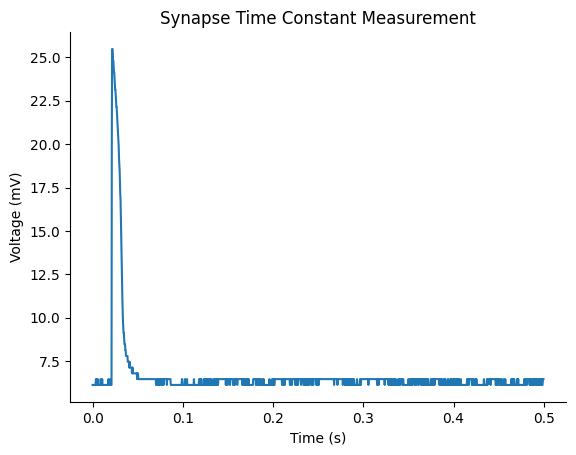

In [56]:

recording_data_path = f'/home/hector/Documents/dynapse-se2-data/time_constant_recordings/{test_type}_test.npy'
[time_values_1,voltages_1]=np.load(recording_data_path)

fig,ax=plt.subplots()
ax.plot(time_values_1, voltages_1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (mV)')
ax.set_title('Synapse Time Constant Measurement')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()


<font size=8> Time Constant Extraction

Text(-1, 2, 'core=0\nleak=[1,20]')

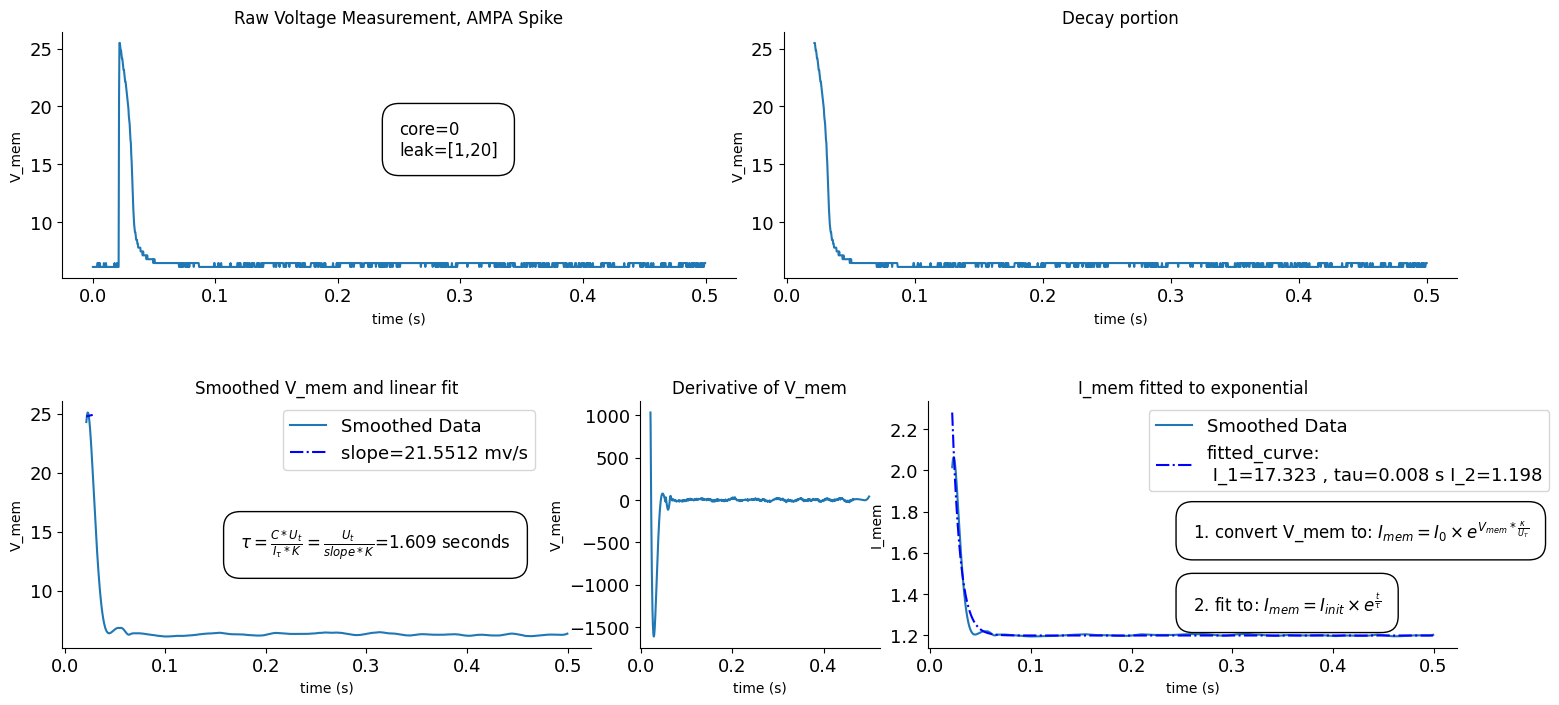

In [58]:

def exp_func(t, A, tau,C):
    return A* np.exp(-t / tau)+C

Cap=7.7e-12
U_T=26e-3
Kappa=0.75
recording_data_path = f'/home/hector/Documents/dynapse-se2-data/time_constant_recordings/{test_type}_test.npy'
spike_recording_data = np.load(recording_data_path, allow_pickle=True)
[raw_time, raw_voltage]=spike_recording_data
recording_window=2000
[raw_time, raw_voltage]=[raw_time[0:recording_window], raw_voltage[0:recording_window]]

# Take the data past the peak point
decay_voltage = raw_voltage[np.argmax(raw_voltage):]
decay_time = raw_time[np.argmax(raw_voltage):]

# Smooth the data and take the derivative
window_length = 201
polyorder=7
voltage_smooth = savgol_filter(decay_voltage, window_length, polyorder)
voltage_derivative = np.gradient(voltage_smooth, decay_time)
        
# Exponential Fit
beta = .75/26
I_mem = np.exp((voltage_smooth) * beta)
initial_guess = [max(I_mem), 1, 0.02]
params, params_covariance = curve_fit(exp_func, decay_time, I_mem, p0=initial_guess, bounds=([0, 0, -2], [np.inf, 2, 2]))

# Linear Fit
window_2=20
window=10
model_linear = LinearRegression()
model_linear.fit(decay_time[0:window].reshape(-1, 1), voltage_smooth[0:window])
y_pred = model_linear.predict(decay_time[0:window].reshape(-1, 1))
residuals = voltage_smooth[0:window] - y_pred
y_pred = model_linear.predict(decay_time[0:window_2].reshape(-1, 1))

#convert from mV to V
slope=model_linear.coef_[0]*1e-3
taul_linear=(U_T)/(abs(slope)*Kappa)

# Create a gridspec object
fig = plt.figure(figsize=(18, 8))
gs = gridspec.GridSpec(2,10)
ax1 = plt.subplot(gs[0, 0:5])
ax2 = plt.subplot(gs[0, 5:10])
ax3 = plt.subplot(gs[1, 0:4])
ax4 = plt.subplot(gs[1, 4:6])
ax5 = plt.subplot(gs[1, 6:10])

# You can adjust the spacing using subplots_adjust or tight_layout as mentioned in the previous responses.
plt.subplots_adjust(wspace=0.5, hspace=0.5)
ax1.plot(raw_time, raw_voltage, label='Raw Data')
ax2.plot(decay_time, decay_voltage, label='Raw Data')
ax3.plot(decay_time, voltage_smooth, label='Smoothed Data')
ax3.plot(decay_time[0:window_2], y_pred[0:window_2], 'b-.', 
         label=f'slope={model_linear.coef_[0]:.4f} mv/s')
ax3.legend(bbox_to_anchor=(.4, 1), loc='upper left',fontsize=13)
ax4.plot(decay_time,voltage_derivative, label='derivative')
ax5.plot(decay_time, I_mem, label='Smoothed Data')
ax5.plot(decay_time, exp_func(decay_time,params[0],params[1],params[2]), 'b-.', label='fitted_curve:\n I_1=%5.3f , tau=%5.3f s I_2=%5.3f' % tuple(params))
ax5.legend(bbox_to_anchor=(.4, 1), loc='upper left',fontsize=13)
#titles
ax1.set_title(f'Raw Voltage Measurement, {test_type} Spike')
ax2.set_title('Decay portion')
ax3.set_title('Smoothed V_mem and linear fit')
ax4.set_title('Derivative of V_mem')
ax5.set_title('I_mem fitted to exponential')

ax1.set_ylabel('V_mem')
ax2.set_ylabel('V_mem')
ax3.set_ylabel('V_mem')
ax4.set_ylabel('V_mem')
ax5.set_ylabel('I_mem')

axes=[ax1,ax2,ax3,ax4,ax5]
for i in axes:
    i.set_xlabel('time (s)')
    i.tick_params(axis='both', which='major', labelsize=13)
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)

# Show the plot
plt.text(.50, .45, r'1. convert V_mem to: $I_{mem}=I_{0} \times e^{V_{mem}*\frac{\kappa}{U_{T}}}$', fontsize=12,
     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'),
     transform=plt.gca().transAxes)

plt.text(-1.3, .4, r'$\tau=\frac{C * U_{t}}{I_{\tau} *K}=\frac{U_{t}}{slope *K}}$='+'%5.3f seconds' % taul_linear, fontsize=12,
     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'),
     transform=plt.gca().transAxes)

plt.text(.50, .15, r'2. fit to: $I_{mem}=I_{init} \times e^\frac{t}{\tau}$', fontsize=12,
     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'),
     transform=plt.gca().transAxes)

plt.text(-1,2 , f'core={core_to_measure}\nleak=[{leak_coarse},{leak_fine}]', fontsize=12,
     bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'),
     transform=plt.gca().transAxes)




<font size=9> Linear time constant approach

Residuals: [0.0009121230766014032]
Slopes: [-13.403639172721428]


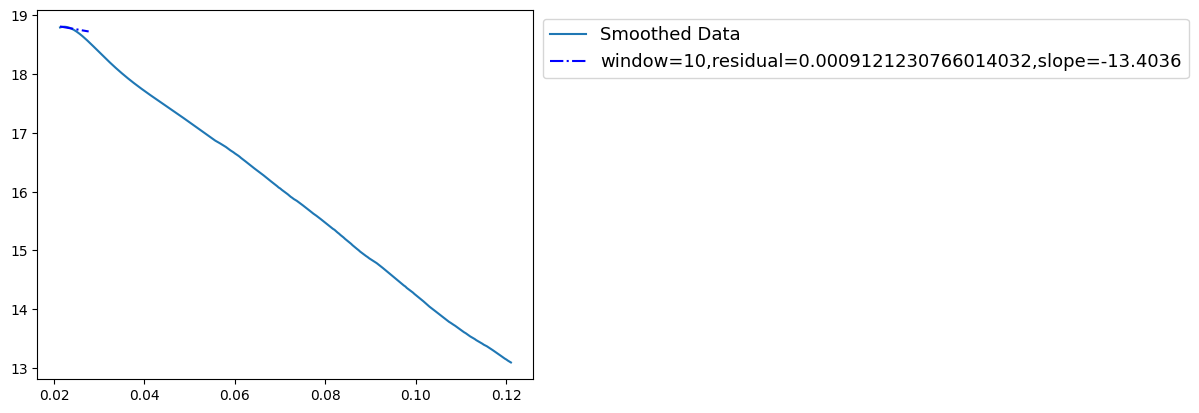

In [56]:
plt.plot(decay_time[0:300], voltage_smooth[0:300], label='Smoothed Data')


residual_list = []
slope_list = []
window_2=20
window=10
model = LinearRegression()
model.fit(decay_time[0:window].reshape(-1, 1), voltage_smooth[0:window])
y_pred = model.predict(decay_time[0:window].reshape(-1, 1))
residuals = voltage_smooth[0:window] - y_pred
residual_list.append(np.sum(residuals**2))
slope_list.append(model.coef_[0])  # Append the slope (coefficient of the model)
#plot dashed lines
y_pred = model.predict(decay_time[0:window_2].reshape(-1, 1))
plt.plot(decay_time[0:window_2], y_pred[0:window_2], 'b-.', 
         label=f'window={window},residual={np.sum(residuals**2)},slope={model.coef_[0]:.4f}')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=13)
print('Residuals:', residual_list)
print('Slopes:', slope_list)



    

In [41]:
fine_values=np.arange(10,255,20)
leak_coarse=0
spike_recording_data=[]
input_events=isi_gen(input_neuron_1,[0],[0])
core_to_measure=0
neuron_to_measure=10
for leak_fine in fine_values:
    #Set leakage and monitor neuron
    set_parameter(myConfig.chips[0].cores[core_to_measure].parameters,'DEAM_ETAU_P',leak_coarse,leak_fine)
    set_parameter(myConfig.chips[0].cores[core_to_measure].parameters,'DEAM_EGAIN_P',5,200)
    myConfig.chips[0].cores[core_to_measure].neuron_monitoring_on = True
    myConfig.chips[0].cores[core_to_measure].monitored_neuron =  neuron_to_measure
    model.apply_configuration(myConfig)
    time.sleep(0.1)
    #Input_events=regular_gen(input_neuron,1,10,1)
    input_events=isi_gen(input_neuron_1,[0],[0])
    #Run
    spike_recording_data.append(measure_spike(board,input_events))
recording_data_path = f'data/time_constant_recordings/{test_type}_sweep_test.npy'
np.save(recording_data_path, spike_recording_data)

FileNotFoundError: [Errno 2] No such file or directory: 'data/time_constant_recordings/AMPA_sweep_test.npy'

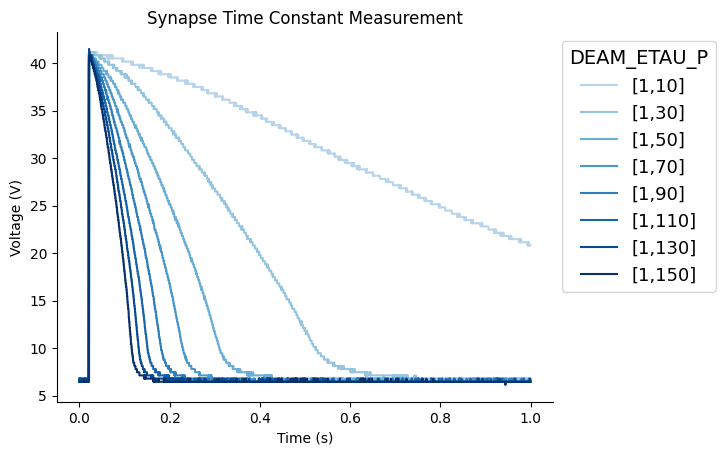

In [16]:
test_type='Ampa'
fine_values=np.arange(10,255,20)

recording_data_path = f'data/time_constant_recordings/{test_type}_sweep_test.npy'
spike_recording_data=np.load(recording_data_path, allow_pickle=True)

fig,ax=plt.subplots()

# Define a color map to generate colors for your lines
colors = cm.Blues(np.linspace(0.3, 1, len(spike_recording_data)-5))

for i, color in zip(range(len(spike_recording_data)-5), colors):
    ax.plot(spike_recording_data[i][0],spike_recording_data[i][1], color=color, label=f'[1,{fine_values[i]}]')

# Create the legend box, and give it a title
legend = ax.legend(bbox_to_anchor=(1, 1), loc='upper left', fontsize=13, title="DEAM_ETAU_P")
plt.setp(legend.get_title(),fontsize=14)  # Setting legend title font size

ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.set_title('Synapse Time Constant Measurement')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.show()

range(0, 13)


Text(0.5, 0.4, '$I_{mem}=I_{0} \\times e^{V_{mem}*\\beta}, \\beta= {.75/26}$')

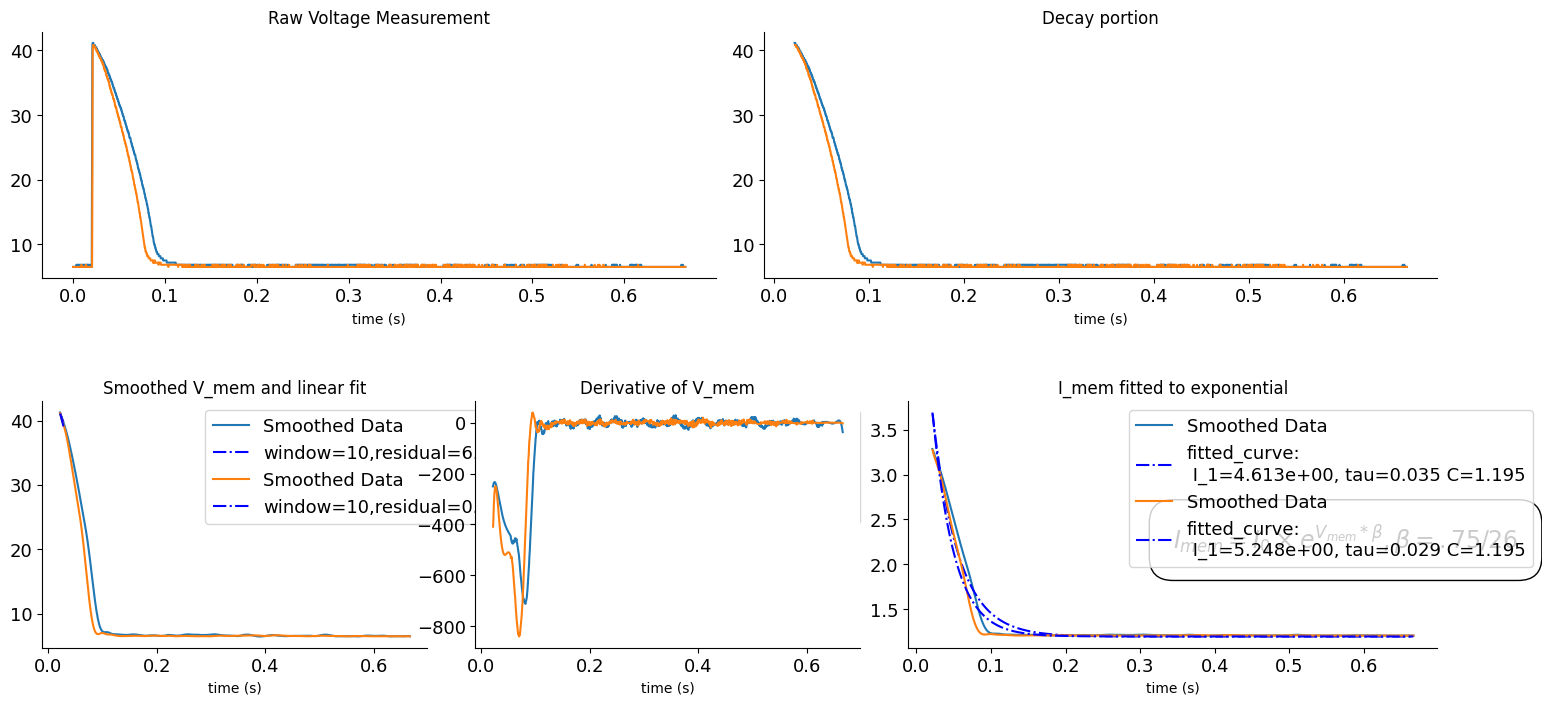

In [36]:
recording_data_path = 'data/time_constant_recordings/Ampa_sweep_test.npy'
spike_recording_data = np.load(recording_data_path, allow_pickle=True)
print(range(len(spike_recording_data)))

 # Create a gridspec object
fig = plt.figure(figsize=(18, 8))
gs = gridspec.GridSpec(2,10)
ax1 = plt.subplot(gs[0, 0:5])
ax2 = plt.subplot(gs[0, 5:10])
ax3 = plt.subplot(gs[1, 0:3])
ax4 = plt.subplot(gs[1, 3:6])
ax5 = plt.subplot(gs[1, 6:10])
# You can adjust the spacing using subplots_adjust or tight_layout as mentioned in the previous responses.
plt.subplots_adjust(wspace=0.5, hspace=0.5)
for i in [10,12]:
     
    def exp_func(t, A, tau,C):
        return A* np.exp(-t / tau)+C

    spike_recording_data = np.load(recording_data_path, allow_pickle=True)
    [raw_time, raw_voltage]=spike_recording_data[i]
    recording_window=2000
    [raw_time, raw_voltage]=[raw_time[0:recording_window], raw_voltage[0:recording_window]]

    # Take the data past the peak point
    decay_voltage = raw_voltage[np.argmax(raw_voltage):]
    decay_time = raw_time[np.argmax(raw_voltage):]

    # Smooth the data and take the derivative
    window_length = 201
    polyorder=7
    voltage_smooth = savgol_filter(decay_voltage, window_length, polyorder)
    voltage_derivative = np.gradient(voltage_smooth, decay_time)
            
    # Exponential Fit
    beta = .75/26
    I_mem = np.exp((voltage_smooth) * beta)
    initial_guess = [max(I_mem), 1, 0.02]
    params, params_covariance = curve_fit(exp_func, decay_time, I_mem, p0=initial_guess, bounds=([0, 0, -2], [np.inf, 2, 2]))

    # Linear Fit
    window_2=20
    window=10
    model = LinearRegression()
    model.fit(decay_time[0:window].reshape(-1, 1), voltage_smooth[0:window])
    y_pred = model.predict(decay_time[0:window].reshape(-1, 1))
    residuals = voltage_smooth[0:window] - y_pred
    y_pred = model.predict(decay_time[0:window_2].reshape(-1, 1))

    ax1.plot(raw_time, raw_voltage, label='Raw Data')
    ax2.plot(decay_time, decay_voltage, label='Raw Data')
    ax3.plot(decay_time, voltage_smooth, label='Smoothed Data')
    ax3.plot(decay_time[0:window_2], y_pred[0:window_2], 'b-.', 
            label=f'window={window},residual={np.sum(residuals**2)},slope={model.coef_[0]:.4f}')
    ax3.legend(bbox_to_anchor=(.4, 1), loc='upper left',fontsize=13)
    ax4.plot(decay_time,voltage_derivative, label='derivative')
    ax5.plot(decay_time, I_mem, label='Smoothed Data')
    ax5.plot(decay_time, exp_func(decay_time,params[0],params[1],params[2]), 'b-.', label='fitted_curve:\n I_1=%5.3e, tau=%5.3f C=%5.3f' % tuple(params))
    ax5.legend(bbox_to_anchor=(.4, 1), loc='upper left',fontsize=13)
#titles
ax1.set_title('Raw Voltage Measurement')
ax2.set_title('Decay portion')
ax3.set_title('Smoothed V_mem and linear fit')
ax4.set_title('Derivative of V_mem')
ax5.set_title('I_mem fitted to exponential')

axes=[ax1,ax2,ax3,ax4,ax5]
for i in axes:
    i.set_xlabel('time (s)')
    i.tick_params(axis='both', which='major', labelsize=13)
    i.spines['right'].set_visible(False)
    i.spines['top'].set_visible(False)

# Show the plot
plt.text(.50, .4, r'$I_{mem}=I_{0} \times e^{V_{mem}*\beta}, \beta= {.75/26}$', fontsize=17,
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=1'),
    transform=plt.gca().transAxes)


<font size=8> Avoid high I_mem values?


In [12]:
#set test parameters
leak_coarse=0
leak_fine=20
neuron_to_measure=10
#set leakage and monitor neuron
set_parameter(myConfig.chips[0].cores[core_to_measure].parameters,'DEAM_ETAU_P',leak_coarse,leak_fine)
set_parameter(myConfig.chips[0].cores[core_to_measure].parameters,'DEAM_EGAIN_P',5,200)
myConfig.chips[0].cores[core_to_measure].neuron_monitoring_on = True
myConfig.chips[0].cores[core_to_measure].monitored_neuron =  neuron_to_measure
model.apply_configuration(myConfig)
time.sleep(0.1)
#input_events=regular_gen(input_neuron,1,10,1)
input_events=isi_gen(input_neuron_1,[0],[0])
#run
[time_values_2,voltages_2]=time_constants.measure_spike(board,input_events)


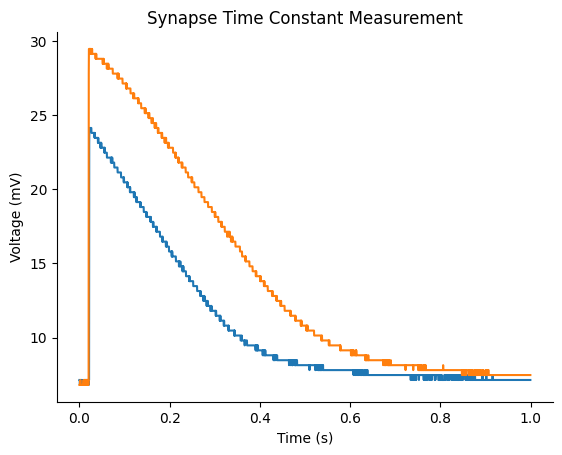

In [13]:

fig,ax=plt.subplots()
ax.plot(time_values_1, voltages_1)
ax.plot(time_values_2, voltages_2)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (mV)')
ax.set_title('Synapse Time Constant Measurement')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()


In [14]:
fine_values=np.arange(10,255,10)
leak_coarse=0
spike_recording_data=[]
input_events=isi_gen(input_neuron,[0],[0])
core_to_measure=0
neuron_to_measure=10
for leak_fine in fine_values:
    #set leakage and monitor neuron
    set_parameter(myConfig.chips[0].cores[core_to_measure].parameters,'DEAM_ETAU_P',leak_coarse,leak_fine)
    set_parameter(myConfig.chips[0].cores[core_to_measure].parameters,'DEAM_EGAIN_P',5,200)
    myConfig.chips[0].cores[core_to_measure].neuron_monitoring_on = True
    myConfig.chips[0].cores[core_to_measure].monitored_neuron =  neuron_to_measure
    model.apply_configuration(myConfig)
    time.sleep(0.1)
    #input_events=regular_gen(input_neuron,1,10,1)
    input_events=isi_gen(input_neuron,[0],[0])
    #run
    spike_recording_data.append(time_constants.measure_spike(board,input_events))

recording_data_path = f'data/time_constant_recordings/Ampa_spike_data_test.npy'
np.save(recording_data_path, spike_recording_data)

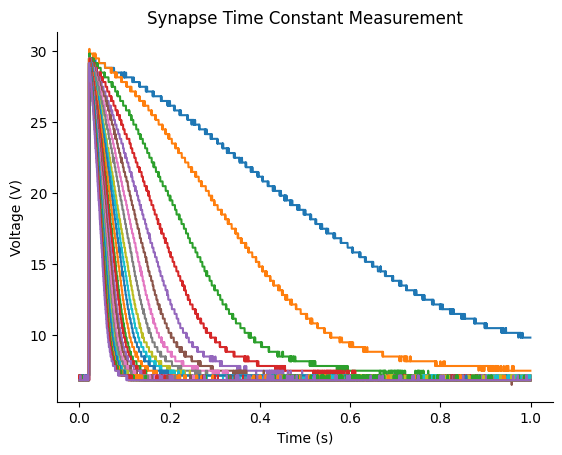

In [24]:
recording_data_path = f'data/time_constant_recordings/Ampa_spike_data_test.npy'
spike_recording_data = np.load(recording_data_path, allow_pickle=True)

fig,ax=plt.subplots()
for i in range(len(spike_recording_data)):
    ax.plot(spike_recording_data[i][0],spike_recording_data[i][1],label=fine_values[i]*10)    
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (V)')
ax.set_title('Synapse Time Constant Measurement')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()


<font size=8> DATA Recording


In [71]:
leak_range=np.arange(100,255,10)
neuron_range = np.arange(0,255,20,dtype=int)
input_events=isi_gen(input_neuron_1,[0],[0])
coarse_value=1
core=2
#Load previous data if exists
try:
    recording_data_path = f'data/time_constant_recordings/AMPA_data_core_{core}_coarse_{coarse_value}.npy'
    if os.path.exists(recording_data_path):
        spike_decay_data_dict = np.load(recording_data_path, allow_pickle=True)
    else:
        pulse_decay_data_dict = {}
    for neuron_i in neuron_range:
        if neuron_i not in pulse_decay_data_dict:
            pulse_decay_data_dict[neuron_i] = {}
        for leak_fine in leak_range:
            if leak_fine not in pulse_decay_data_dict[neuron_i]:
                #set leakage and monitor neuron
                set_parameter(myConfig.chips[0].cores[core_to_measure].parameters,'DEAM_ETAU_P',coarse_value,leak_fine)
                set_parameter(myConfig.chips[0].cores[core_to_measure].parameters,'DEAM_EGAIN_P',5,200)
                myConfig.chips[0].cores[core_to_measure].neuron_monitoring_on = True
                myConfig.chips[0].cores[core_to_measure].monitored_neuron =  neuron_to_measure
                model.apply_configuration(myConfig)
                time.sleep(0.1)
                #input_events=regular_gen(input_neuron,1,10,1)                #run
                pulse_decay_data_dict[neuron_i][leak_fine] = time_constants.measure_spike(board,input_events)
                np.save(recording_data_path, spike_recording_data)
    print(f'neuron {neuron_i} recorded')
finally:
    print(f'Test finalized in at neuron: {neuron_i} and leak_fine: {leak_fine}')

Test finalized in at neuron: 120 and leak_fine: 120


UnboundLocalError: local variable 'time_values' referenced before assignment

<font size=8> Time Constant Extraction


def extract_linear_portion(time, voltage, window_length=501, threshold=None):
    # Ensure that data is 2D for the model
    time = time.reshape(-1, 1)
    voltage = voltage.reshape(-1, 1)
    
    # Calculate residuals for each window
    residuals = np.array([calculate_residuals(time[i:i+window_length], voltage[i:i+window_length]) for i in range(len(time) - window_length + 1)])
   
    # Determine threshold
    if threshold is None:  # if no threshold is provided, calculate it from the data
        threshold = np.mean(residuals) + .1 * np.std(residuals)  # Adjust this as needed

    # Find where residuals exceed threshold (indicating non-linear portion)
    print(threshold)
    print(residuals)
    print(np.where(residuals > threshold))
    indices_where_nonlinear = np.where(residuals > threshold)[0]

    # If there is no linear portion according to the threshold, return empty arrays
    if len(indices_where_nonlinear) == 0:
        print('No linear portion found')
        return np.array([]), np.array([])
    
    linear_end_index = indices_where_nonlinear[0]
    print('Linear portion ends at index', linear_end_index)
    # Return only the linear portion of the data
    return time[:linear_end_index], voltage[:linear_end_index]


def calculate_residuals(x, y):
    model = LinearRegression()
    model.fit(x.reshape(-1, 1), y)
    y_pred = model.predict(x.reshape(-1, 1))
    residuals = y - y_pred
    return np.sum(residuals**2)